Импортируем библиотеки: для работы с картинками, массивами и с выводом изображений.

In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [138]:
def plt_print_pic(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    plt.imshow(rgb_img)
    plt.show()

Читаем картинки из папки pictures:

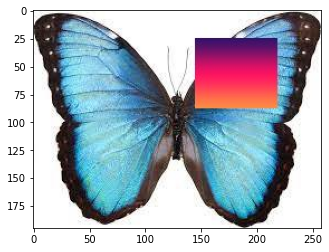

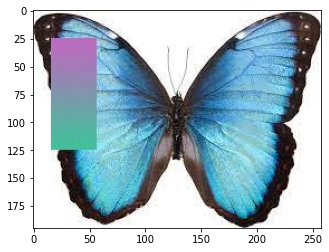

In [145]:
path1 = r"/Users/valeriazaborovskaya/1C task/pics/picture_grad_1.jpg"
path2 = r"/Users/valeriazaborovskaya/1C task/pics/picture_grad_2.jpg"

# читаем в формате BGR
image1 = cv2.imread(path1) 
image2 = cv2.imread(path2)

plt_print_pic(image1)
plt_print_pic(image2)

Необходимо найти прямоугольник с градиентной заливкой, будем искать края прямоугольника, пользуясь поиском производных 
от дискретных величин. Производные можно вычислить путем свертки изображения с фильтрами и по отдельности. Используя центральный метод конечных разностей и фильтры:

In [140]:
def initialize_x_filter(size):
    x_filter = np.zeros(size)
    h , w = size
    x_filter[h//2][0]= -1
    x_filter[h//2][-1] = 1
    return x_filter

def initialize_y_filter(size):
    y_filter = np.zeros(size)
    h , w = size
    y_filter[0][h//2]= -1
    y_filter[-1][h//2] = 1
    return y_filter

In [141]:
def padding(image):
    padded_image = np.pad(image , ((1,1),(1,1)) , 'constant', constant_values=(0,0) )
    return padded_image
  
def conv2d(image, ftr):
    s = ftr.shape + tuple(np.subtract(image.shape, ftr.shape) + 1)
    sub_image = np.lib.stride_tricks.as_strided(image, shape = s, strides = image.strides * 2)
    return np.einsum('ij,ijkl->kl', ftr, sub_image) 

Используем градиент изображения для определения границ. Математически ребро - это изменение чисел при переходе от одного пикселя к другому (то есть градиент изображения). Результатом свертки изображения с помощью фильтра является изображение из черного и белого цветов. Белый цвет указывает на края

In [146]:
def black_image(image, path_to_write):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    x_filter = initialize_x_filter((3, 3))
    y_filter = initialize_y_filter((3, 3))

    I_x = conv2d( padding(gray_image) ,  x_filter)
    I_y = conv2d( padding(gray_image) ,  y_filter)
    
    G = np.sqrt( np.power(I_x, 2)  +  np.power(I_y, 2) )
    G = np.where (G > 5, G , 0)
    
    cv2.imwrite(path_to_write , G)

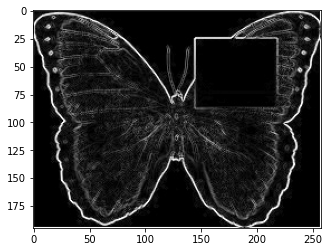

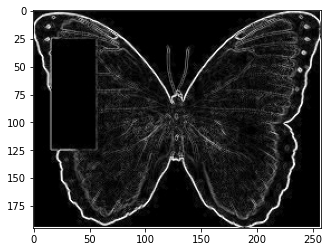

In [147]:
path1 = r"/Users/valeriazaborovskaya/1C task/pics/picture_new1.jpg"
path2 = r"/Users/valeriazaborovskaya/1C task/pics/picture_new2.jpg"

black_image(image1, path1)
black_image(image2, path2)

image1 = cv2.imread(path1)
image2 = cv2.imread(path2)

plt_print_pic(image1)
plt_print_pic(image2)

Теперь когда у нас есть удобные для обработки изображения, напишем функцию для поиска прямоугольников: найдем их контуры с помощью findContour из cv2

In [148]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0 - p1).astype('float'), (p2 - p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, None)
            else:
                retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
    return squares

def print_squares(path):
    img = cv2.imread(path)
    squares = find_squares(img)
    cv2.drawContours(img, squares, -1, (0, 255, 0), 3 )
    plt_print_pic(img)

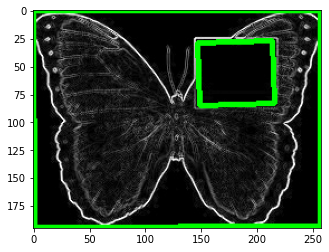

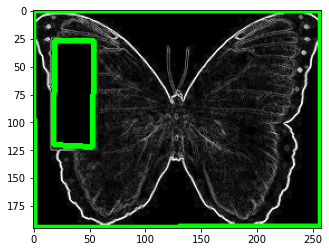

In [149]:
print_squares(path1)
print_squares(path2)